# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [1]:
# parse & handle data
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# clustering
import hdbscan

# dimensionaliy reduction
import umap
import umap.plot

# visualization
from matplotlib import cm
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [2]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [3]:
# read node information
node_info = (pd.read_csv('data/node_information.csv', index_col = 0, header = None)
                 .rename_axis("node"))
node_info.shape

(3597, 932)

In [4]:
# read edge lists (train and test)
train = pd.read_csv('data/train.txt', header = None, sep = " ").rename(columns = {0: "node1", 1: "node2", 2: "y"})
test  = pd.read_csv('data/test.txt' , header = None, sep = " ").rename(columns = {0: "node1", 1: "node2"})

# sort edge lists (so lower numbered node is always in first column)
train = train[["node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True).assign(y = train.y)
test  = test[[ "node1", "node2"]].apply(lambda x: np.sort(x), axis = 1, raw = True)

In [5]:
# create graph based on edge list
G_train = nx.from_pandas_edgelist(train.loc[train.y == 1], "node1", "node2")

In [6]:
def get_gcc(graph):
    # Is the given graph connected?
    connected = nx.is_connected(graph) # check if the graph is connected or not
    if connected:
        print("The graph is connected")
        return graph
    
    print("The graph is not connected")
    
    # Find the number of connected components
    num_of_cc = nx.number_connected_components(graph)
    print("Number of connected components: {}".format(num_of_cc))
    
    # Get the greatest connected component subgraph
    gcc_nodes = max(nx.connected_components(graph), key=len)
    gcc = graph.subgraph(gcc_nodes)
    node_fraction = gcc.number_of_nodes() / float(graph.number_of_nodes())
    edge_fraction = gcc.number_of_edges() / float(graph.number_of_edges())
    
    print("Fraction of nodes in GCC: {:.3f}".format(node_fraction))
    print("Fraction of edges in GCC: {:.3f}".format(edge_fraction))

    return gcc

# Get the GGC of the network
gcc = get_gcc(graph=G_train)

The graph is connected


### 3. Missing values, duplicates and find possible data leakage

#### 3.1 Node Information

In [7]:
node_info.isnull().sum().sum()

0

no missing values

In [8]:
# number of duplicates
print(node_info.shape)
node_info_tf = node_info.assign(duplicate = lambda df_: df_.duplicated())
node_info_tf.duplicate.value_counts()

(3597, 932)


False    2972
True      625
Name: duplicate, dtype: int64

625 nodes have exactly the same embedding! But do they also have the same set of neighbours?

In [9]:
# get neighbors of each node
node_info_tf = (node_info_tf
    .assign(neighbors = lambda df_: [tuple(set([i for i in nx.all_neighbors(G_train, node)])) for node in df_.index]))

In [10]:
# number of duplicates
print(node_info_tf.shape)
node_info_tf = node_info_tf.assign(duplicate = lambda df_: df_.duplicated())
node_info_tf.duplicate.value_counts()

(3597, 934)


False    3585
True       12
Name: duplicate, dtype: int64

12 nodes have the same embedding as well as the same set of neighbors!

In [11]:
node_info_tf.loc[node_info_tf.duplicate]

,1,2,3,4,5,6,7,8,9,10,...,925,926,927,928,929,930,931,932,duplicate,neighbors
node,,,,,,,,,,,,,,,,,,,,,
1024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
1344,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,"(3809,)"
1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
2870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
3319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,"(3809,)"
3492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,True,"(3809,)"


#### 3.2 Edge lists

There are no duplicates in the dataset! Also no edges that are present in both train and test!

In [12]:
# number of duplicates in train
print(train.shape)
train.duplicated(subset = ["node1", "node2"]).value_counts()

(10496, 3)


False    10496
dtype: int64

In [13]:
# number of duplicates in test
print(test.shape)
test.duplicated().value_counts()

(3498, 2)


False    3498
dtype: int64

In [14]:
# number of edges present in both datasets
all_data = pd.concat([train[["node1", "node2"]], test])
print(all_data.shape)
all_data.duplicated().value_counts()

(13994, 2)


False    13994
dtype: int64

Are there any predictions where both nodes are the same? (if so, prediction should always be 1)

In [15]:
print(train.loc[train["node1"] == train["node2"]].shape)
print(test.loc[test["node1"] == test["node2"]].shape)

(31, 3)
(17, 2)


In [16]:
all_data.loc[all_data["node1"] == all_data["node2"]].shape

(48, 2)

### 4. Clustering based on Node Embedding

Let us see if we can create a meaningful clustering based on the embeddings of each node. This is based on the intuition that nodes that share many keywords should likely belong to the same cluster (e.g. Wikipedia sports vs math pages).

However, the embedding of each node is of very high dimension. Let us first try to reduce the dimensionality before clustering the data. First, I thought about using PCA -- however, for this problem it is probably a very bad idea. Why? PCA finds the global structure (only linear!) but local neighborhoods are not preserved (far away points can become nearest neighbors in projected subspace). But all that I am interested in, is to find the local neighborhoods. So if I run PCA I would reduce the dimension but lose this information. In consequence, I will use UMAP.

In [115]:
# create umap embedding of nodes
reducer = umap.UMAP(n_neighbors=30,
                    min_dist=0,
                    n_components=2).fit(node_info)

embedding = reducer.transform(node_info)

Text(0.5, 1.0, 'UMAP projection (first 2 dim) of Node information')

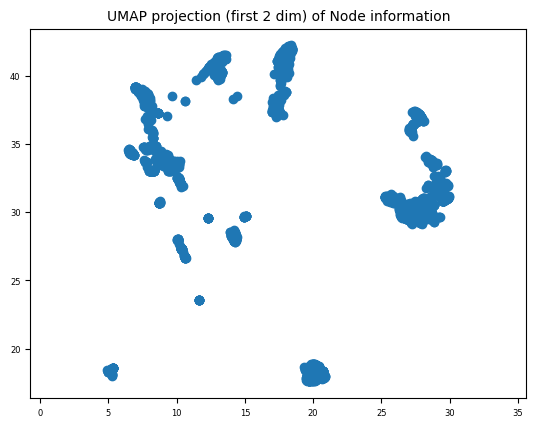

In [116]:
# plot umap embedding of nodes
plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection (first 2 dim) of Node information')

In [123]:
# use umap embedding to cluster nodes
clusterer = hdbscan.HDBSCAN(min_samples=10, min_cluster_size = 300)
clusterer.fit(embedding)

clustered = (clusterer.labels_ >= 0)
print(f"Share of clustered nodes: {np.sum(clustered) / node_info.shape[0]}")

Share of clustered nodes: 0.9705309980539338


In [124]:
# look at clusters
np.unique(clusterer.labels_, return_counts = True)

(array([-1,  0,  1,  2,  3,  4], dtype=int64),
 array([ 106,  408, 1141, 1108,  516,  318], dtype=int64))

<AxesSubplot: ylabel='$\\lambda$ value'>

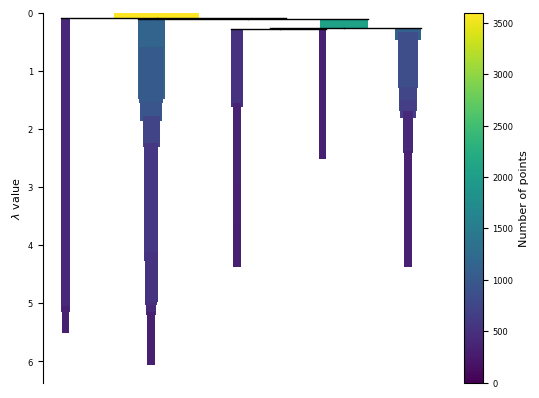

In [125]:
# visualize clusters of HDBSCAN
clusterer.condensed_tree_.plot()

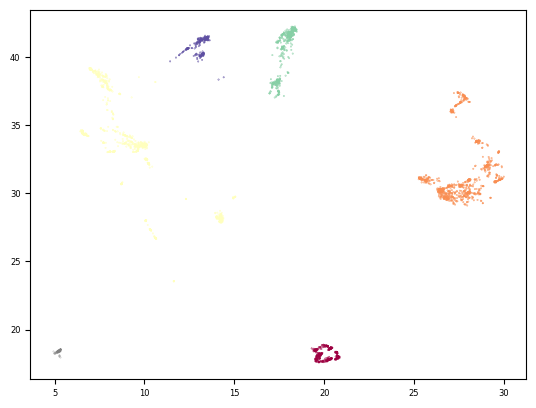

In [126]:
# plot clustered nodes based on their embedding
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            color=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=clusterer.labels_[clustered],
            s=0.1,
            cmap='Spectral')

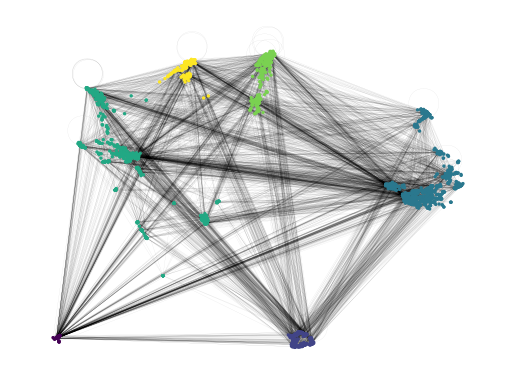

In [127]:
# use embedding and cluster of each node to visualize graph
data = dict()
for i, node in enumerate(node_info.index):
    data[node] = {"emb_1": embedding[i][0], "emb_2": embedding[i][1], "cluster": clusterer.labels_[i]}

nodes = G_train.nodes()
pos = {node: [data[node]["emb_1"], data[node]["emb_2"]] for node in nodes}
labels = [data[node]["cluster"] for node in nodes]

nx.draw_networkx_edges(G_train, pos, alpha=0.2, width = 0.1)
nc = nx.draw_networkx_nodes(G_train, pos, nodelist=nodes, node_size=2, node_color=labels)
plt.axis('off')

plt.show()

In [128]:
# compute connectedness between groups
node_stats = (pd.DataFrame.from_dict(data, orient = "index")
    .assign(degree = lambda df_: [G_train.degree(node) for node in df_.index])
    .assign(neighbors = lambda df_: [[df_.loc[node].cluster for node in G_train.neighbors(node)] for node in df_.index])
    .assign(neighbors = lambda df_: [[lst.count(i) for i in np.unique(labels)] for lst in df_.neighbors])
)

node_stats = (pd.concat([node_stats, node_stats.neighbors.apply(pd.Series).divide(node_stats.degree, axis=0).round(2)], axis=1)
    .rename(columns = {idx: cluster for idx, cluster in zip(range(len(np.unique(labels))), np.unique(labels))})
)

agg_dict = {col: "mean" for col in list(np.unique(labels))}
agg_dict["degree"] = "sum"
agg_dict["cluster"] = "count"
(node_stats
    .groupby("cluster").agg(agg_dict).rename(columns = {"cluster" : "nbr_nodes"}).round(2)
    .assign(avg_degree = lambda df_: (df_.degree / df_.nbr_nodes).round(2))
)

,-1,0,1,2,3,4,degree,nbr_nodes,avg_degree
cluster,,,,,,,,,
-1,0.11,0.09,0.29,0.27,0.13,0.12,652,106,6.15
0,0.08,0.11,0.30,0.31,0.12,0.08,1194,408,2.93
1,0.10,0.11,0.30,0.28,0.12,0.08,3197,1141,2.80
2,0.10,0.11,0.27,0.30,0.13,0.08,3158,1108,2.85
3,0.08,0.11,0.29,0.29,0.16,0.07,1365,516,2.65
4,0.10,0.12,0.26,0.31,0.11,0.09,930,318,2.92
